In [1]:
import pandas as pd
from numpy import nan
import numpy as np
import matplotlib.pyplot as plt

# Windmill Preprocessing
## Clean and prepare windmill data for GIS

In [6]:
# static cols
cols = ['GSRN','Turbine_type','Parent_GSRN','BBR_municipal','Placement','UTM_x','UTM_y','Capacity_kw','Rotor_diameter','Navhub_height','In_service','Out_service']

In [7]:
windmills = pd.read_parquet('data/ITU_DATA/masterdatawind.parquet', columns=cols)

In [9]:
windmills.sort_values(["In_service"])

,GSRN,Turbine_type,Parent_GSRN,BBR_municipal,Placement,UTM_x,UTM_y,Capacity_kw,Rotor_diameter,Navhub_height,In_service,Out_service
79776,571313114900743984,H,None,707,None,NaN,NaN,10.0,7.1,21.4,1816-03-29 05:56:08.067,NaT
85086,571313174116253585,W,None,265,LAND,694932.0,6175477.0,850.0,52.0,44.0,1816-03-29 05:56:08.067,NaT
85087,571313174116253585,W,None,265,LAND,694932.0,6175477.0,850.0,52.0,44.0,1816-03-29 05:56:08.067,NaT
79777,571313114900743984,H,None,707,None,NaN,NaN,10.0,7.1,21.4,1816-03-29 05:56:08.067,NaT
6507,570714700000011283,W,None,400,LAND,505771.2,6109811.3,30.0,0.1,0.1,1977-12-22 00:00:00.000,2002-11-01
...,...,...,...,...,...,...,...,...,...,...,...,...
85021,571313174002139191,H,None,336,None,NaN,NaN,5.0,2.9,3.1,NaT,NaT
85139,571313179100992129,H,None,250,None,NaN,NaN,25.0,11.0,23.5,NaT,NaT
85140,571313179100992129,H,None,250,None,NaN,NaN,25.0,11.0,23.5,NaT,NaT
85141,571313179100992129,H,None,250,None,NaN,NaN,25.0,11.0,23.5,NaT,NaT


### Filter In_service from till now

In [ ]:
windmills = windmills[windmills['Out_service'].isna()]

In [ ]:
windmills

### Remove duplicated data
Windmills have duplicated data by different reviewers.    

In [ ]:
windmills.drop_duplicates(subset = "GSRN", keep = 'first', ignore_index = True, inplace = True)
windmills.shape

9168 Contains:    
- H: Household turbine : No UTM_xy locations 
- W: Single turbine : full data
- P: Turbine park : No UTM_xy locations
- M: Turbine in a park : No power record in settlement data


In [ ]:
print('Household: ',windmills[windmills['Turbine_type'] == 'H'].shape)
print('Single: ',windmills[windmills['Turbine_type'] == 'W'].shape)
print('Park: ',windmills[windmills['Turbine_type'] == 'P'].shape)
print('In a Park: ',windmills[windmills['Turbine_type'] == 'M'].shape)

Household has no coordinates, filter it out

In [ ]:
windmills = windmills[windmills['Turbine_type'] != 'H']
len(windmills)

### Fill Turbine park xy by calculate their CENTRIODs.

In [ ]:
aggs = {'UTM_x':lambda x : x.mean(),
        'UTM_y':lambda x : x.mean()}
w_temp = windmills[windmills['Turbine_type'] == 'M'].groupby(['Parent_GSRN'], as_index = False).agg(aggs).rename(columns={'Parent_GSRN':'GSRN','UTM_x':'x_c','UTM_y':'y_c'})
w_temp

In [ ]:
windmills = pd.merge(windmills, w_temp, on='GSRN', how='left')
# location
windmills[['UTM_x']] = windmills.apply(lambda x: x[['UTM_x']].fillna(value = x['x_c']), axis=1)[['UTM_x']]
windmills[['UTM_y']] = windmills.apply(lambda x: x[['UTM_y']].fillna(value = x['y_c']), axis=1)[['UTM_y']]
windmills = windmills.drop(columns=['x_c','y_c'])
windmills

In [ ]:
windmills = windmills.drop(columns = "Out_service")

Cause a bug in ArcGIS file import, we need to add a 'z' at the end of GSRN and Parent_GSRN

In [ ]:
windmills['GSRN'] = [x+'z' for x in windmills['GSRN']]
windmills['Parent_GSRN'].fillna('',inplace = True)
windmills['Parent_GSRN'] = [x+'z' for x in windmills['Parent_GSRN']]

In [ ]:
windmills.to_csv('data/windmills_gis.csv', index=False)

## After ArcGIS data extraction 
Merge data

In [16]:
windmills = pd.read_excel('data/windmill_extract.xlsx')
windmills.head(3)

,OBJECTID,GSRN,Turbine_type,Parent_GSRN,BBR_municipal,Placement,UTM_x,UTM_y,Capacity_kw,Rotor_diameter,Navhub_height,Elevation,Slope,Aspect,grid,LandCover_Corine,LABEL3,CODE_18
0,1,570714700000001420z,M,570714700000050787z,360,LAND,628479.00,6071056.0,400.0,35.0,32.0,0.9600,2.097087,152.500809,813,12.0,Non-irrigated arable land,211
1,2,570715000000049002z,M,570715000000048869z,550,LAND,478674.48,6099264.0,600.0,42.0,45.0,12.0052,1.230658,44.436138,1190,12.0,Non-irrigated arable land,211
2,3,570714700000003837z,M,570714700000050794z,360,LAND,633430.00,6089565.0,1000.0,54.0,50.0,5.0000,1.847866,144.217468,814,12.0,Non-irrigated arable land,211


In [17]:
windmills["GSRN"] = windmills["GSRN"].apply(lambda x : x[:len(x)-1])
windmills["Parent_GSRN"] = windmills["Parent_GSRN"].apply(lambda x : x[:len(x)-1])

In [ ]:
# roughness_dic = {210:0.0, 
#                 220:0.004,  
#                 200:0.005, 
#                 202:0.005, 
#                 140:0.03, 
#                 150:0.05, 
#                 11:0.1, 
#                 31:0.1, 
#                 130:0.1, 
#                 10:0.1, 
#                 20:0.3, 
#                 30:0.3, 
#                 160:0.5, 
#                 120:0.5, 
#                 170:0.6, 190:1.0, 40:1.5, 50:1.5, 60:1.5, 70:1.5, 90:1.5, 100:1.5, 110:1.5 , 180:11, -1:0.0}

In [4]:
np.unique(windmills["CODE_18"])

array([112, 121, 123, 131, 133, 142, 211, 222, 231, 242, 243, 312, 313,
       321, 322, 324, 331, 411, 412, 421, 423, 512, 523])

In [18]:
roughness_dic = {112:0.1, 
                121:0.1, 
                123:0.1, 
                131:0.0005,  
                133:0.1, 
                142:0.1,
                211:0.005, 
                222:0.05, 
                231:0.03, 
                242:0.3,
                243:0.3, 
                312:0.5, 
                313:0.5, 
                321:0.03, 
                322:0.03, 
                324:0.6, 
                331:0.0003, 
                411:0.005, 
                412:0.0005, 
                421:0.005, 
                423:0.0005, 
                512:0.000001,
                523:0.000001 
                }

In [19]:
windmills['Roughness'] = windmills['CODE_18'].apply(lambda x: roughness_dic[x])

In [20]:
windmills['Slope'] = round(windmills['Slope'],3)
windmills['Aspect'] = round(windmills['Aspect'],3)
windmills['Elevation'] = round(windmills['Elevation'],3)
windmills.fillna({'Slope':0, 'Aspect':0, 'Elevation':0, 'Roughness':0.000001}, inplace=True)
windmills = windmills.drop(columns=["LandCover_Corine", "LABEL3", "CODE_18", "OBJECTID"])

In [21]:
windmills.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6729 entries, 0 to 6728
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   GSRN            6729 non-null   object 
 1   Turbine_type    6729 non-null   object 
 2   Parent_GSRN     6729 non-null   object 
 3   BBR_municipal   6729 non-null   int64  
 4   Placement       6729 non-null   object 
 5   UTM_x           6729 non-null   float64
 6   UTM_y           6729 non-null   float64
 7   Capacity_kw     6729 non-null   float64
 8   Rotor_diameter  6260 non-null   float64
 9   Navhub_height   6288 non-null   float64
 10  Elevation       6729 non-null   float64
 11  Slope           6729 non-null   float64
 12  Aspect          6729 non-null   float64
 13  grid            6729 non-null   int64  
 14  Roughness       6729 non-null   float64
dtypes: float64(9), int64(2), object(4)
memory usage: 788.7+ KB


In [22]:
windmills.to_csv('data/windmill_cleaned_2.csv', index=False)

# Filter Single and Park

In [10]:
dtype = {"GSRN":str, "Turbine_type":str, "Parent_GSRN":str, "BBR_municipal":int, "Placement": str, "Capacity_kw":float, "Rotor_diameter":float, "Navhub_height":float, "Elevation":float, "Slope":float, "Aspect":float, "grid":int, "Roughness":float}
windmill = pd.read_csv('data/windmill_cleaned_2.csv', dtype=dtype)

In [13]:
len(windmill[windmill["Turbine_type"]=="W"])

3927

In [4]:
windmill_park = windmill[windmill["Turbine_type"]=="P"]
windmill_park

,GSRN,BBR_municipal,Placement,Capacity_kw,Elevation,Slope,Aspect,grid,Roughness
27,570715000000024764,630,LAND,300.0,96.000,0.000,-1.000,1111,0.100
31,570715000000029677,787,LAND,81.0,21.020,1.338,150.343,1369,0.100
60,570715000000044229,530,LAND,400.0,42.000,0.352,-0.877,1196,0.300
77,570715000000021817,751,LAND,3300.0,86.000,1.087,12.569,1032,0.100
112,570715000000041235,661,LAND,1125.0,2.000,0.000,-1.000,1324,0.100
...,...,...,...,...,...,...,...,...,...
6688,570714700000050077,265,LAND,900.0,43.000,0.000,-1.000,736,0.005
6693,570715000000022692,710,LAND,1800.0,76.712,0.410,4.089,1074,0.100
6696,570715000000010934,851,LAND,160.0,40.226,3.557,34.363,1120,0.100
6702,570714700000050763,370,LAND,450.0,40.913,3.147,61.168,775,0.100


In [5]:
temp = windmill[windmill["Turbine_type"]=="M"]
temp_1 = pd.DataFrame(temp.groupby("Parent_GSRN")["Rotor_diameter"].apply(list)).reset_index()
temp_2 = pd.DataFrame(temp.groupby("Parent_GSRN")["Navhub_height"].apply(list)).reset_index()
temp_1 = pd.merge(temp_1, temp_2, on="Parent_GSRN")
temp_2 = pd.DataFrame(temp.groupby("Parent_GSRN")["Elevation"].apply(list)).reset_index()
temp_1 = pd.merge(temp_1, temp_2, on="Parent_GSRN")
temp_2 = pd.DataFrame(temp.groupby("Parent_GSRN")["Slope"].apply(list)).reset_index()
temp_1 = pd.merge(temp_1, temp_2, on="Parent_GSRN")
temp_2 = pd.DataFrame(temp.groupby("Parent_GSRN")["Aspect"].apply(list)).reset_index()
temp_1 = pd.merge(temp_1, temp_2, on="Parent_GSRN")
temp_2 = pd.DataFrame(temp.groupby("Parent_GSRN")["Roughness"].apply(list)).reset_index()
temp_1 = pd.merge(temp_1, temp_2, on="Parent_GSRN")

In [6]:
temp_1 = temp_1.rename({"Parent_GSRN":"GSRN", "Rotor_diameter":"Rotor_diameter_group", "Navhub_height":"Navhub_height_group","Elevation":"Elevation_group", "Slope":"Slope_group", "Aspect":"Aspect_group", "Roughness":"Roughness_group"}, axis=1)
windmill_park = pd.merge(windmill_park, temp_1, on="GSRN", how="left")


In [8]:
windmill_park.head(3)

,GSRN,BBR_municipal,Placement,Capacity_kw,Elevation,Slope,Aspect,grid,Roughness,Rotor_diameter_group,Navhub_height_group,Elevation_group,Slope_group,Aspect_group,Roughness_group
0,570715000000024764,630,LAND,300.0,96.00,0.000,-1.000,1111,0.1,"[16.0, 16.0]","[24.0, 24.0]","[97.23700000000001, 96.0]","[4.301, 0.127]","[150.329, 27.346]","[0.1, 0.1]"
1,570715000000029677,787,LAND,81.0,21.02,1.338,150.343,1369,0.1,"[8.0, 7.0, 8.0, 7.0]","[12.0, 15.0, 12.0, 15.0]","[21.02, 21.02, 21.02, 21.02]","[1.338, 1.338, 1.338, 1.338]","[150.343, 150.343, 150.343, 150.343]","[0.1, 0.1, 0.1, 0.1]"
2,570715000000044229,530,LAND,400.0,42.00,0.352,-0.877,1196,0.3,"[26.0, 26.0]","[30.0, 30.0]","[42.132, 42.883]","[2.444, 1.659]","[35.396, 290.92400000000004]","[0.1, 0.3]"


In [14]:
windmill_park["Navhub_height"] = windmill_park["Navhub_height_group"].apply(lambda x: np.mean(x).astype(float))
windmill_park["Rotor_diameter"] = windmill_park["Rotor_diameter_group"].apply(lambda x: np.mean(x).astype(float))
windmill_park["Elevation"] = windmill_park["Elevation_group"].apply(lambda x: np.mean(x).astype(float))
windmill_park["Slope"] = windmill_park["Slope_group"].apply(lambda x: np.mean(x).astype(float))
windmill_park["Roughness"] = windmill_park["Roughness_group"].apply(lambda x: np.mean(x).astype(float))

In [15]:
windmill_park

,GSRN,BBR_municipal,Placement,Capacity_kw,Elevation,Slope,Aspect,grid,Roughness,Rotor_diameter_group,Navhub_height_group,Elevation_group,Slope_group,Aspect_group,Roughness_group,Navhub_height,Rotor_diameter
0,570715000000024764,630,LAND,300.0,96.618500,2.214000,-1.000,1111,0.100000,"[16.0, 16.0]","[24.0, 24.0]","[97.23700000000001, 96.0]","[4.301, 0.127]","[150.329, 27.346]","[0.1, 0.1]",24.0,16.0
1,570715000000029677,787,LAND,81.0,21.020000,1.338000,150.343,1369,0.100000,"[8.0, 7.0, 8.0, 7.0]","[12.0, 15.0, 12.0, 15.0]","[21.02, 21.02, 21.02, 21.02]","[1.338, 1.338, 1.338, 1.338]","[150.343, 150.343, 150.343, 150.343]","[0.1, 0.1, 0.1, 0.1]",13.5,7.5
2,570715000000044229,530,LAND,400.0,42.507500,2.051500,-0.877,1196,0.200000,"[26.0, 26.0]","[30.0, 30.0]","[42.132, 42.883]","[2.444, 1.659]","[35.396, 290.92400000000004]","[0.1, 0.3]",30.0,26.0
3,570715000000021817,751,LAND,3300.0,87.693800,1.884000,12.569,1032,0.100000,"[47.0, 47.0, 47.0, 47.0, 47.0]","[40.0, 40.0, 40.0, 40.0, 40.0]","[86.0, 82.92299999999999, 96.0, 90.586, 82.96]","[1.082, 2.062, 1.955, 3.1069999999999998, 1.214]","[12.944, 312.736, 239.528, 318.952, 145.401]","[0.1, 0.1, 0.1, 0.1, 0.1]",40.0,47.0
4,570715000000041235,661,LAND,1125.0,2.000000,0.089400,-1.000,1324,0.100000,"[27.0, 27.0, 27.0, 27.0, 27.0]","[31.5, 31.5, 31.5, 31.5, 31.5]","[2.0, 2.0, 2.0, 2.0, 2.0]","[0.447, 0.0, 0.0, 0.0, 0.0]","[50.093999999999994, -1.0, -1.0, -1.0, -1.0]","[0.1, 0.1, 0.1, 0.1, 0.1]",31.5,27.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
436,570714700000050077,265,LAND,900.0,43.900000,1.082667,-1.000,736,0.036667,"[31.0, 31.0, 31.0]","[30.0, 30.0, 30.0]","[46.7, 42.0, 43.0]","[2.844, 0.40399999999999997, 0.0]","[23.476, 2.0, -1.0]","[0.1, 0.005, 0.005]",30.0,31.0
437,570715000000022692,710,LAND,1800.0,75.205667,1.990667,4.089,1074,0.100000,"[48.0, 48.0, 48.0]","[46.0, 46.0, 46.0]","[76.703, 76.921, 71.993]","[0.423, 2.294, 3.255]","[0.765, 304.968, 170.459]","[0.1, 0.1, 0.1]",46.0,48.0
438,570715000000010934,851,LAND,160.0,40.226000,3.557000,34.363,1120,0.100000,[28.0],[31.0],[40.226],[3.557],[34.363],[0.1],31.0,28.0
439,570714700000050763,370,LAND,450.0,40.913000,3.147000,61.168,775,0.100000,"[24.6, 24.6, 24.6, 24.6, 24.6, 24.6, 24.6, 24....","[32.5, 32.5, 32.5, 32.5, 32.5, 32.5, 32.5, 32....","[40.913000000000004, 40.913000000000004, 40.91...","[3.147, 3.147, 3.147, 3.147, 3.147, 3.147, 3.1...","[61.168, 61.168, 61.168, 61.168, 61.168, 61.16...","[0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1]",32.5,24.6


In [16]:
windmill_park.to_csv('data/windmill_park_cleaned.csv', index=False)

# Observe Land and Single

In [147]:
windmill_SL = pd.read_csv("data/windmills_single_LAND.csv")
len(windmill_SL)

3910

#### Capacity_kw distribution

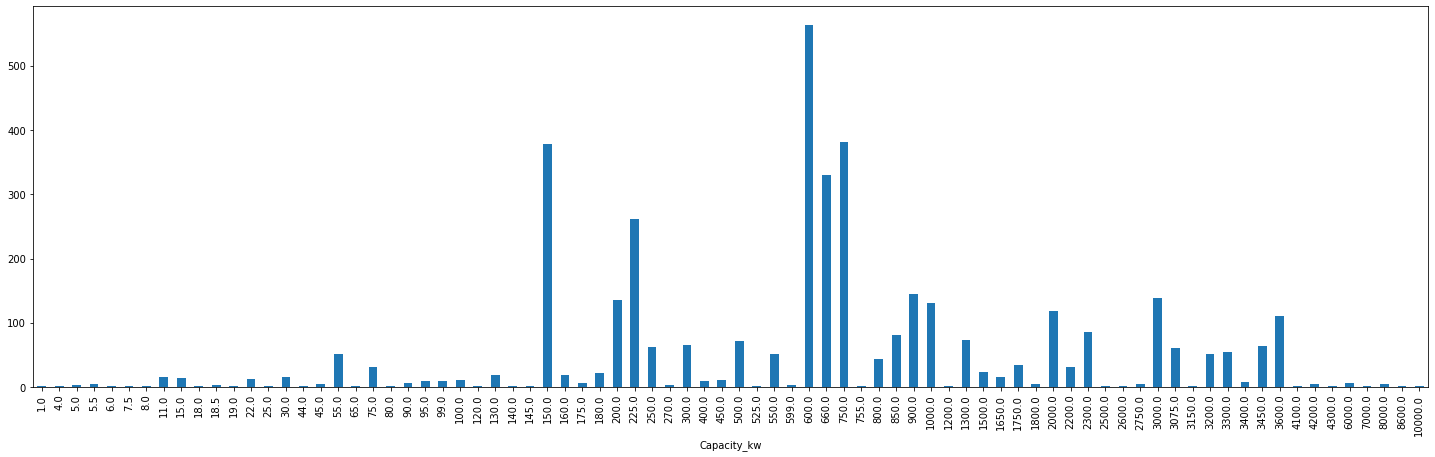

In [148]:
plt.figure(figsize=(25,7))
windmill_SL.groupby("Capacity_kw").count()["GSRN"].plot.bar()

### Choose Capacity == 600

In [149]:
windmill_LW600 = windmill_SL[windmill_SL["Capacity_kw"] == 600]
len(windmill_LW600)

564

In [150]:
windmill_LW600.groupby(["Rotor_diameter", "Navhub_height", "Slope", "Elevation", "Roughness"])["GSRN"].count() \
                .reset_index(name='count') \
                .sort_values(['count'], ascending=False)

,Rotor_diameter,Navhub_height,Slope,Elevation,Roughness,count
393,44.0,46.0,0.000,1.000,0.1,5
392,44.0,46.0,0.000,0.000,0.1,5
180,44.0,35.0,0.000,0.000,0.1,4
294,44.0,45.0,0.000,0.000,0.1,3
484,48.0,46.0,0.000,22.000,0.1,3
...,...,...,...,...,...,...
174,43.0,50.0,3.883,24.664,0.1,1
173,43.0,50.0,3.232,23.869,0.1,1
172,43.0,50.0,2.877,19.190,0.1,1
171,43.0,50.0,2.779,80.000,0.1,1


## Select windmills with the same condition

In [151]:
windmills_exp = windmill_LW600[windmill_LW600["Rotor_diameter"] == 44.0][windmill_LW600["Navhub_height"] == 46.0][windmill_LW600["Slope"] == 0][windmill_LW600["Elevation"] == 0][windmill_LW600["Roughness"] == 0.1]
windmills_exp

,GSRN,Turbine_type,BBR_municipal,Placement,Capacity_kw,Rotor_diameter,Navhub_height,Elevation,Slope,Aspect,grid,Roughness
1884,570715000000034435,W,760,LAND,600.0,44.0,46.0,0.0,0.0,-1.0,1321,0.1
2279,570715000000034497,W,760,LAND,600.0,44.0,46.0,0.0,0.0,-1.0,1321,0.1
2462,570715000000034374,W,760,LAND,600.0,44.0,46.0,0.0,0.0,-1.0,1321,0.1
3745,570715000000034466,W,760,LAND,600.0,44.0,46.0,0.0,0.0,-1.0,1321,0.1
3844,570715000000034404,W,760,LAND,600.0,44.0,46.0,0.0,0.0,-1.0,1321,0.1


In [152]:
windmills_exp.to_csv("data/windmills_same_cond.csv", index=False)

# Observe Park

In [154]:
windmill_PL = pd.read_csv("data/windmills_park_LAND.csv")
len(windmill_PL)

430

In [208]:
windmill_PL["Navhub_height_mean"] = windmill_PL["Navhub_height_group"].apply(lambda x: np.mean(np.array(x[1:-1].split(", ")).astype(float)))
windmill_PL["Rotor_diameter_mean"] = windmill_PL["Rotor_diameter_group"].apply(lambda x: np.mean(np.array(x[1:-1].split(", ")).astype(float)))

In [209]:
windmill_PL

,GSRN,BBR_municipal,Placement,Capacity_kw,Elevation,Slope,Aspect,grid,Roughness,Rotor_diameter_group,Navhub_height_group,Elevation_group,Slope_group,Aspect_group,Roughness_group,Navhub_height_mean,Rotor_diameter_mean
0,570715000000024764,630,LAND,300.0,96.000,0.000,-1.000,1111,0.100,"[16.0, 16.0]","[24.0, 24.0]","[97.23700000000001, 96.0]","[4.301, 0.127]","[150.329, 27.346]","[0.1, 0.1]",24.0,16.0
1,570715000000029677,787,LAND,81.0,21.020,1.338,150.343,1369,0.100,"[8.0, 7.0, 8.0, 7.0]","[12.0, 15.0, 12.0, 15.0]","[21.02, 21.02, 21.02, 21.02]","[1.338, 1.338, 1.338, 1.338]","[150.343, 150.343, 150.343, 150.343]","[0.1, 0.1, 0.1, 0.1]",13.5,7.5
2,570715000000044229,530,LAND,400.0,42.000,0.352,-0.877,1196,0.300,"[26.0, 26.0]","[30.0, 30.0]","[42.132, 42.883]","[2.444, 1.659]","[35.396, 290.92400000000004]","[0.1, 0.3]",30.0,26.0
3,570715000000021817,751,LAND,3300.0,86.000,1.087,12.569,1032,0.100,"[47.0, 47.0, 47.0, 47.0, 47.0]","[40.0, 40.0, 40.0, 40.0, 40.0]","[86.0, 82.92299999999999, 96.0, 90.586, 82.96]","[1.082, 2.062, 1.955, 3.1069999999999998, 1.214]","[12.944, 312.736, 239.528, 318.952, 145.401]","[0.1, 0.1, 0.1, 0.1, 0.1]",40.0,47.0
4,570715000000041235,661,LAND,1125.0,2.000,0.000,-1.000,1324,0.100,"[27.0, 27.0, 27.0, 27.0, 27.0]","[31.5, 31.5, 31.5, 31.5, 31.5]","[2.0, 2.0, 2.0, 2.0, 2.0]","[0.447, 0.0, 0.0, 0.0, 0.0]","[50.093999999999994, -1.0, -1.0, -1.0, -1.0]","[0.1, 0.1, 0.1, 0.1, 0.1]",31.5,27.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
425,570714700000050077,265,LAND,900.0,43.000,0.000,-1.000,736,0.005,"[31.0, 31.0, 31.0]","[30.0, 30.0, 30.0]","[46.7, 42.0, 43.0]","[2.844, 0.40399999999999997, 0.0]","[23.476, 2.0, -1.0]","[0.1, 0.005, 0.005]",30.0,31.0
426,570715000000022692,710,LAND,1800.0,76.712,0.410,4.089,1074,0.100,"[48.0, 48.0, 48.0]","[46.0, 46.0, 46.0]","[76.703, 76.921, 71.993]","[0.423, 2.294, 3.255]","[0.765, 304.968, 170.459]","[0.1, 0.1, 0.1]",46.0,48.0
427,570715000000010934,851,LAND,160.0,40.226,3.557,34.363,1120,0.100,[28.0],[31.0],[40.226],[3.557],[34.363],[0.1],31.0,28.0
428,570714700000050763,370,LAND,450.0,40.913,3.147,61.168,775,0.100,"[24.6, 24.6, 24.6, 24.6, 24.6, 24.6, 24.6, 24....","[32.5, 32.5, 32.5, 32.5, 32.5, 32.5, 32.5, 32....","[40.913000000000004, 40.913000000000004, 40.91...","[3.147, 3.147, 3.147, 3.147, 3.147, 3.147, 3.1...","[61.168, 61.168, 61.168, 61.168, 61.168, 61.16...","[0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1]",32.5,24.6


In [183]:
"[24.0, 24.0]"[1:-1].split(", ")

['24.0', '24.0']